# P-multigrid Example

In [3]:
# dependencies
using LFAToolkit
using LinearAlgebra
using Pkg
Pkg.activate("./")
Pkg.instantiate()
using Plots

 Activating environment at `~/Dev/LFAToolkit.jl/examples/jupyter/Project.toml`


In [4]:
# setup
finep = 3
coarsep = 2
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangeBasis(coarsep, finep, dimension, lagrangequadrature=true)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
jacobi = Jacobi(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, jacobi, [ctofbasis])

p-multigrid preconditioner

max eigenvalue: 0.09254471891408153


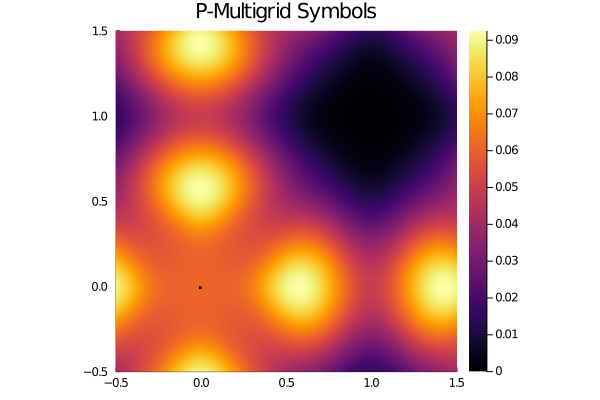

In [11]:
# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [0.636]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) % 2 >  π/32
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(xrange, maxeigenvalues, title="P-Multigrid Symbols")
    ylims!(0.0, max(maxeigenvalues...))
# -- 2D --
elseif dimension == 2
    # setup
    ω = [0.964]
    v = [2, 2]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xrange,
        maxeigenvalues,
        title="P-Multigrid Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end